In [2]:
import sys
sys.path.append("/home/benjamin/RewardCurriculum/")

import os
os.system("export MKL_SERVICE_FORCE_INTEL=1")

import gymnasium as gym
from collections import defaultdict
import panda_gym
from stable_baselines3.common.vec_env import DummyVecEnv
import json
import numpy as np
import tqdm

import os
from utils.configs import get_config
from utils.env_wrappers import make_vec_env, get_env
from argparse import Namespace
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import matplotlib.font_manager as font_manager

font_dir = ['.']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

In [4]:
def rollout_episodes(env, learner, n_episodes=1, desired_position=None, task=None):
    if task is None:
        weights = np.zeros((1, learner.scheduler.reward_dim))
        weights[:, -1] = 1

    positions = []
    rewards = []
    for _ in range(n_episodes):
        terminated = False
        obs = env.reset()
        if desired_position is not None:
            position = env.get_attr("task")[0].get_goal()
            position[3:] = desired_position
            env.env_method("set_goal", position)
            obs["desired_goal"] = position
        
        if desired_position is not None:
            positions.append(desired_position)
        else:
            positions.append(obs["desired_goal"][:, 3:])
            
        while not terminated:            
            act = learner.predict(obs, weights=weights)[0]
            obs, reward, terminated, info = env.step(act)

        rewards.append(reward)
        
    return rewards, positions

In [13]:
os.chdir("/home/benjamin/RewardCurriculum")
results_dir = "/home/benjamin/RewardCurriculum/results/panda_pick_and_place_long"

x_coords = np.arange(-0.15, 0.16, 0.02)
x_dict = {np.round(value, 2): index for index, value in enumerate(x_coords)}
y_coords = np.arange(-0.15, 0.16, 0.02)
y_dict = {np.round(value, 2): index for index, value in enumerate(y_coords)}
z_coords = np.arange(0.02, 0.21, 0.02)
z_dict = {np.round(value, 2): index for index, value in enumerate(z_coords)}

X, Y, Z = np.meshgrid(x_coords, y_coords, z_coords)
desired_positions = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

In [22]:
generalization_results = defaultdict(list)

for subfolder in tqdm.tqdm(os.listdir(results_dir)):
    folder_path = os.path.join(results_dir, subfolder)
    if not os.path.isdir(folder_path):
        continue
    
    args = Namespace()
    args.env_name = json.load(open(os.path.join(folder_path, "config.json"), "r"))["environment"]["env_name"]
    args.seed = json.load(open(os.path.join(folder_path, "config.json"), "r"))["seed"]
    args.config_path = os.path.join(folder_path, "config_original.json")
    args.continue_from = None

    remaining_args = ["--environment.wrapper_kwargs.0.reward_threshold", "-0.05"]
    
    config = get_config(args.config_path, args, remaining_args)
    config["environment"]["wrappers"] += ["SingleTaskRewardWrapper"]
    config["environment"]["wrapper_kwargs"] += [{}]
    
    make_env_fn = lambda wrappers, wrapper_kwargs, ignore_keyword="ignore" : get_env(config["environment"]["env_name"], wrappers=wrappers, wrapper_kwargs=wrapper_kwargs, ignore_keyword=ignore_keyword)
    env = make_vec_env(make_env_fn, 
                        n_envs=config["environment"]["n_envs"], 
                        env_kwargs={"wrappers": config["environment"]["wrappers"], "wrapper_kwargs": config["environment"]["wrapper_kwargs"]},
                        monitor_kwargs={"allow_early_resets": True},
                        seed=config["seed"], vec_env_cls=DummyVecEnv)
    
    learner = config["learner_class"].load(os.path.join(folder_path, "evaluations", "best_model.zip"), env=env)
    
    cl_type = str(config["learner_kwargs"]["scheduler_class"]).split(" ")[-1][2:-2]
    
    positions = []
    rewards = []
    for position in tqdm.tqdm(desired_positions):
        reward, desired_position = rollout_episodes(env, learner, n_episodes=1, desired_position=position)
        rewards += reward
        positions += desired_position
        
    rewards = np.stack(rewards)
    positions = np.stack(desired_positions)
    
    generalization_results[cl_type].append((rewards, positions))

  0%|          | 0/31 [00:00<?, ?it/s]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


  6%|▋         | 2/31 [09:43<2:27:36, 305.39s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 10%|▉         | 3/31 [16:02<2:38:01, 338.63s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 13%|█▎        | 4/31 [19:42<2:11:23, 291.99s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 16%|█▌        | 5/31 [25:53<2:18:50, 320.40s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 19%|█▉        | 6/31 [29:30<1:58:49, 285.16s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 23%|██▎       | 7/31 [35:32<2:04:13, 310.55s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 26%|██▌       | 8/31 [41:25<2:04:06, 323.78s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 29%|██▉       | 9/31 [47:08<2:00:56, 329.84s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 32%|███▏      | 10/31 [51:22<1:47:16, 306.52s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 35%|███▌      | 11/31 [55:00<1:33:08, 279.44s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/benjamin/miniconda3/envs/rew_curr/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 45%|████▌     | 14/31 [1:04:50<1:04:01, 225.95s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 48%|████▊     | 15/31 [1:10:40<1:08:30, 256.92s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 52%|█████▏    | 16/31 [1:16:49<1:11:38, 286.55s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 55%|█████▍    | 17/31 [1:20:53<1:04:06, 274.75s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 58%|█████▊    | 18/31 [1:27:02<1:05:15, 301.19s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 61%|██████▏   | 19/31 [1:30:43<55:38, 278.24s/it]  

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 65%|██████▍   | 20/31 [1:34:21<47:48, 260.80s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 68%|██████▊   | 21/31 [1:40:30<48:45, 292.53s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 71%|███████   | 22/31 [1:44:08<40:35, 270.59s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 74%|███████▍  | 23/31 [1:48:42<36:12, 271.60s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 77%|███████▋  | 24/31 [1:52:24<29:57, 256.79s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 81%|████████  | 25/31 [1:56:30<25:21, 253.66s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 84%|████████▍ | 26/31 [2:02:39<23:59, 287.93s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 87%|████████▋ | 27/31 [2:06:17<17:48, 267.21s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 90%|█████████ | 28/31 [2:09:55<12:36, 252.32s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 94%|█████████▎| 29/31 [2:13:34<08:04, 242.28s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


 97%|█████████▋| 30/31 [2:17:11<03:54, 234.90s/it]

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


100%|██████████| 31/31 [2:20:49<00:00, 272.56s/it]


In [23]:
import pickle
pickle.dump(generalization_results, open(os.path.join(results_dir, "generalization_results.pkl"), "wb"))

In [14]:
import pickle
generalization_results = pickle.load(open(os.path.join(results_dir, "generalization_results.pkl"), "rb"))
generalization_results.keys()

dict_keys(['Random', 'CurrOT', 'SetterSolver', 'ALPGMM', 'ManualTask', 'SACX'])

['Times New Roman']


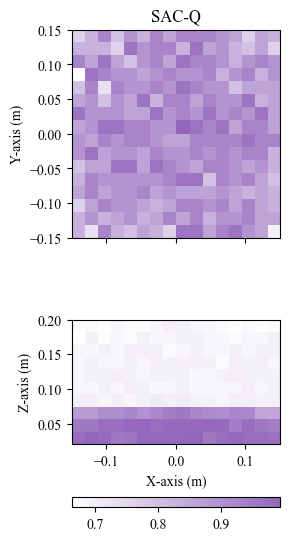

In [15]:
keys_to_plot = ["SACX"]
plot_titles = {
    "SetterSolver": "Setter-Solver",
    "CurrOT": "CurrOT", 
    "ALPGMM": "ALP-GMM", 
    "Random": "Random", 
    "ManualTask": "Main task",
    "SACX": "SAC-Q"
}

cmaps = {
    "SetterSolver": LinearSegmentedColormap.from_list("SetterSolver", [(1, 1, 1), (44 / 256, 160 / 256, 44 / 256)], N=128),
    "CurrOT": LinearSegmentedColormap.from_list("CurrOT", [(1, 1, 1), (255 / 256, 127 / 256, 14 / 256)], N=128),
    "ALPGMM": LinearSegmentedColormap.from_list("ALPGMM", [(1, 1, 1), (31 / 256, 119 / 256, 180 / 256)], N=128),
    "Random": LinearSegmentedColormap.from_list("Random", [(1, 1, 1), (140 / 256, 86 / 256, 75 / 256)], N=128),
    "ManualTask": LinearSegmentedColormap.from_list("ManualTask", [(1, 1, 1), (227 / 256, 119 / 256, 194 / 256)], N=128),
    "SACX": LinearSegmentedColormap.from_list("SACX", [(1, 1, 1), (148 / 256, 103 / 256, 189 / 256)], N=128)
}

print(plt.rcParams['font.family'])
plt.rcParams['font.family'] = ['Times New Roman']

fig, axes = plt.subplots(2, len(keys_to_plot), figsize=(3 * len(keys_to_plot), 10), sharex=True)
axes = np.reshape(axes, (2, -1))

for idx, cl_algo in enumerate(keys_to_plot):
    reward_data = []
    goal_data = []
    for run in generalization_results[cl_algo]:
        reward_data.append(run[0])
        goal_data.append(run[1])
        
    reward_data = np.concatenate(reward_data, axis=0).reshape(len(reward_data), -1, 1).mean(axis=0)
    goal_data = np.concatenate(goal_data, axis=0).reshape(len(goal_data), -1, 3).mean(axis=0)
    
    
    unique_positions = np.unique(goal_data[:, :2], axis=0)
    img = np.zeros(X.shape[:2])
    for position in unique_positions:
        mask = (goal_data[:, 0] == position[0]) * (goal_data[:, 1] == position[1])
        img[x_dict[np.round(position[0], 2)], y_dict[np.round(position[1], 2)]] = reward_data[mask].mean()
    
    axes[0, idx].set_title(plot_titles[cl_algo])
    axes[0, idx].imshow(img, origin='lower', extent=[-0.15, 0.15, -0.15, 0.15], cmap=cmaps[cl_algo])
    
    unique_positions = np.unique(goal_data[:, [0, 2]], axis=0)
    img = np.zeros((X.shape[0], X.shape[2]))
    for position in unique_positions:
        mask = (goal_data[:, 0] == position[0]) * (goal_data[:, 2] == position[1])
        img[x_dict[np.round(position[0], 2)], z_dict[np.round(position[1], 2)]] = reward_data[mask].mean()
    im = axes[1, idx].imshow(img.T, origin='lower', extent=[-0.15, 0.15, 0.02, 0.2], cmap=cmaps[cl_algo])
    axes[1, idx].set_xlabel("X-axis (m)")
    
    plt.colorbar(im, ax=axes[1, idx], location="bottom")
    
    if idx > 0:
        axes[0, idx].get_yaxis().set_visible(False)
        axes[1, idx].get_yaxis().set_visible(False)
    else:
        axes[0, idx].set_ylabel("Y-axis (m)")
        axes[1, idx].set_ylabel("Z-axis (m)")
    

plt.tight_layout()
plt.subplots_adjust(bottom=0.4, top=0.99, hspace=-0.31, wspace=0.17)
plt.savefig(os.path.join(results_dir, "generalization_results_sacx.pdf"))
plt.savefig(os.path.join(results_dir, "generalization_results_sacx.svg"))